In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_data, validation_data, test_data = tfds.load('deep_weeds', split=['train[:80%]', 'train[81%:90%]', 'train[91%:]'], as_supervised=True)

TARGET_SIZE = (128, 128)
TARGET_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

train_data = train_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))


#steps = 41
train_data = train_data.shuffle(1024) #.batch(150)
validation_data = validation_data.shuffle(1024) #.batch(25)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of training samples: 14007
Number of validation samples: 1576
Number of test samples: 1576


tf.Tensor(
[[[[0.31176472 0.28039217 0.21176471]
   [0.83137256 0.7754902  0.7117647 ]
   [0.48235294 0.4137255  0.3480392 ]
   ...
   [0.9607843  0.9676471  0.8656863 ]
   [0.9009804  0.91568625 0.8509804 ]
   [0.41960785 0.4392157  0.39509803]]

  [[0.7607843  0.73137254 0.6617647 ]
   [0.65686274 0.6068627  0.5539216 ]
   [0.23431373 0.17450981 0.13333334]
   ...
   [0.95       0.96960783 0.87352943]
   [0.5882353  0.5882353  0.5382353 ]
   [0.18039216 0.16960785 0.1509804 ]]

  [[0.5323529  0.5088235  0.44313726]
   [0.1754902  0.13431373 0.09705883]
   [0.17254902 0.12156863 0.12156863]
   ...
   [0.8539216  0.88235295 0.7980392 ]
   [0.8813726  0.8745098  0.845098  ]
   [0.32352942 0.2754902  0.28529412]]

  ...

  [[0.14803922 0.15196079 0.16764706]
   [0.21764706 0.22156863 0.2372549 ]
   [0.06960785 0.07352941 0.08921569]
   ...
   [0.6872549  0.72843134 0.50784314]
   [0.34215686 0.41764706 0.19705883]
   [0.78431374 0.8607843  0.69215685]]

  [[0.13039216 0.14607844 0.157843

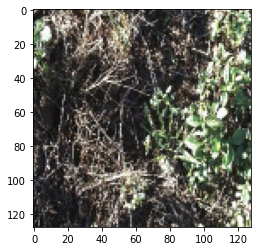

In [3]:
input = keras.Input(shape=TARGET_SHAPE)
normalizer = keras.layers.experimental.preprocessing.Normalization()
preprocess = normalizer(input)
normalizer.set_weights([np.array([0] * 3), np.array([255**2] * 3)])

image_batch, label_batch = next(iter(train_data))
test = normalizer(image_batch)
print(test)
print(label_batch)
plt.imshow(tf.reshape(test, (128, 128, 3)))

In [19]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.GlobalAveragePooling2D(),
])
#base_model.trainable = False
#print(base_model.summary())
#img = train_data.take(1)
#print(img)
#image_batch, label_batch = next(iter(train_data))
#print(image_batch)
#plt.imshow(image_batch / 255.0)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

features = base_model(preprocess)
dense_layer = keras.layers.Dense(512, 
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                     bias_regularizer=keras.regularizers.l2(1e-4),
                                     activity_regularizer=keras.regularizers.l2(1e-5)
                                    )
dropout = keras.layers.Dropout(0.25)
classifier_head = keras.layers.Dense(9, 
                                     activation='softmax',
                                     
                                    )

outputs = classifier_head(dropout(dense_layer(features)))

print(outputs.shape)

model = keras.Model(input, outputs)

print(model.summary())

(None, 9)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
sequential_2 (Sequential)    (None, 512)               1187328   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 4617      
Total params: 1,454,608
Trainable params: 1,454,601
Non-trainable params: 7
__________________________________

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

#print(model.summary())
history2 = model.fit(train_data.batch(25)
, epochs=10
, validation_data=validation_data.batch(10)
, validation_steps=140
, steps_per_epoch=561
)

#model.save_weights("classifier_head_weights.tf")

Epoch 1/10
  2/561 [..............................] - ETA: 46s - loss: 0.8227 - accuracy: 0.6000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0412s vs `on_train_batch_end` time: 0.0618s). Check your callbacks.


561/561 [==============================] - 62s 110ms/step - loss: 0.6747 - accuracy: 0.7818 - val_loss: 0.6756 - val_accuracy: 0.7836
Epoch 2/10
561/561 [==============================] - 60s 108ms/step - loss: 0.6625 - accuracy: 0.7855 - val_loss: 0.7064 - val_accuracy: 0.7807
Epoch 3/10
561/561 [==============================] - 61s 109ms/step - loss: 0.6549 - accuracy: 0.7882 - val_loss: 0.6409 - val_accuracy: 0.7979
Epoch 4/10
561/561 [==============================] - 61s 108ms/step - loss: 0.6471 - accuracy: 0.7935 - val_loss: 0.6467 - val_accuracy: 0.8129
Epoch 5/10
561/561 [==============================] - 60s 108ms/step - loss: 0.6427 - accuracy: 0.7941 - val_loss: 0.6618 - val_accuracy: 0.7957
Epoch 6/10
561/561 [==============================] - 61s 109ms/step - loss: 0.6355 - accuracy: 0.7967 - val_loss: 0.6277 - val_accuracy: 0.8079
Epoch 7/10
561/561 [==============================] - 61s 108ms/step - loss: 0.6142 - accuracy: 0.8030 - val_loss: 0.6443 - val_accuracy: 0.8

In [24]:
trloss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 2s 106ms/step - loss: 0.6467 - accuracy: 0.7982
0.7982233762741089


<Figure size 432x288 with 0 Axes>

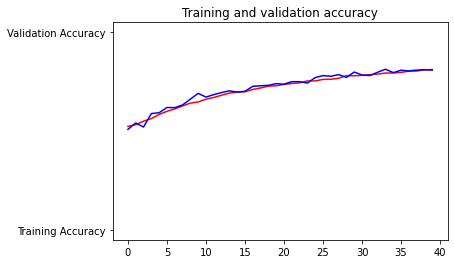

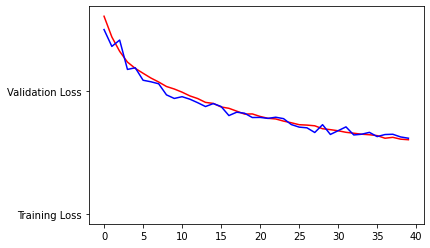

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
#print(history.history)

acc+=history2.history['accuracy']
val_acc+=history2.history['val_accuracy']
loss+= history2.history['loss']
val_loss+=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()